In [1]:
pip install kmodes

In [2]:
import pandas as pd
import numpy as np
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
purchase_data = pd.read_csv('purchase_data.csv')


In [4]:
# Compute Customer Spending Summary
customer_spending = purchase_data.groupby('Customer ID')['Purchase Amount'].agg(['sum', 'mean', 'count'])
customer_spending.columns = ['Total_Spent', 'Average_Purchase', 'Purchase_Count']

# Get most frequently purchased category per customer
most_purchased_category = purchase_data.groupby(['Customer ID', 'Product Category']).size().reset_index(name='count')
most_purchased_category = most_purchased_category.loc[most_purchased_category.groupby('Customer ID')['count'].idxmax()][['Customer ID', 'Product Category']]
customer_spending = customer_spending.merge(most_purchased_category, on='Customer ID', how='left')



# Prepare Data for Clustering
X = customer_spending[['Total_Spent', 'Purchase_Count', 'Product Category']].copy()
X['Product Category'] = X['Product Category'].astype('category')
X['Product Category'] = X['Product Category'].cat.codes  # Convert category to numerical labels

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X[['Total_Spent', 'Purchase_Count', 'Product Category']] = scaler.fit_transform(X[['Total_Spent', 'Purchase_Count', 'Product Category']])


print(X.head())


   Total_Spent  Purchase_Count  Product Category
0    -0.520682        0.310685          1.096835
1    -0.763074        0.310685         -0.936852
2    -0.362784       -0.310685         -0.936852
3    -0.371137        0.310685         -0.936852
4    -0.616963        0.000000          1.096835


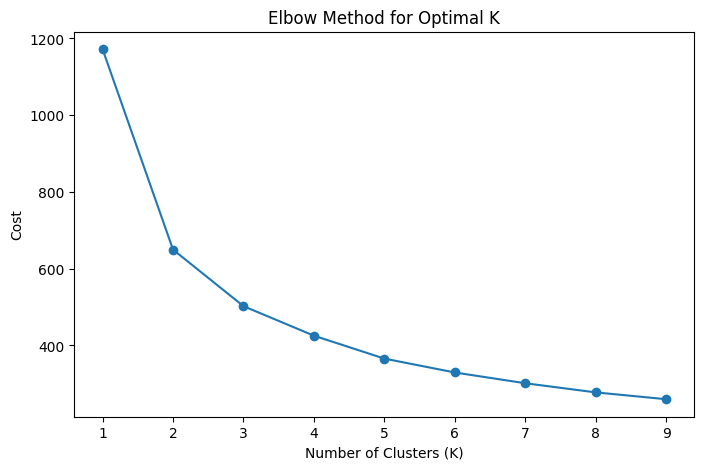

In [5]:
# Determine Optimal Number of Clusters (Elbow Method)
costs = []
K_range = range(1, 10)
for k in K_range:
    kproto = KPrototypes(n_clusters=k, init='Huang', n_init=5, verbose=0)
    clusters = kproto.fit_predict(X, categorical=[2])
    costs.append(kproto.cost_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(K_range, costs, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal K')
plt.show()

In [6]:
optimal_k = 3
kproto = KPrototypes(n_clusters=optimal_k, init='Huang', n_init=5, verbose=1)
clusters = kproto.fit_predict(X, categorical=[2])
customer_spending['Cluster'] = clusters

# Save Clustered Data
customer_spending.to_csv('customer_clusters.csv', index=False)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 85, ncost: 533.1624453347358
Run: 1, iteration: 2/100, moves: 34, ncost: 519.029823755726
Run: 1, iteration: 3/100, moves: 24, ncost: 511.8957430719682
Run: 1, iteration: 4/100, moves: 12, ncost: 509.9048923842196
Run: 1, iteration: 5/100, moves: 12, ncost: 508.8156413749271
Run: 1, iteration: 6/100, moves: 12, ncost: 508.1694446862157
Run: 1, iteration: 7/100, moves: 2, ncost: 508.11810680632465
Run: 1, iteration: 8/100, moves: 1, ncost: 508.110865050381
Run: 1, iteration: 9/100, moves: 5, ncost: 507.927912921499
Run: 1, iteration: 10/100, moves: 2, ncost: 507.90663243554724
Run: 1, iteration: 11/100, moves: 0, ncost: 507.90663243554724
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 80, ncost: 547.534744509472
Run: 2, iteration: 2/100, moves: 49, ncost: 523.8937623408709
Run: 2, iteration: 3/100, moves: 33, n

In [7]:
cluster_summary = customer_spending.groupby('Cluster').agg({
    'Total_Spent': ['mean', 'min', 'max'],
    'Purchase_Count': ['mean', 'min', 'max'],
    'Product Category': lambda x: x.mode()[0]  # Most common category in each cluster
}).reset_index()

cluster_summary.columns = ['Cluster', 'Avg_Spent', 'Min_Spent', 'Max_Spent',
                           'Avg_Purchases', 'Min_Purchases', 'Max_Purchases',
                           'Most_Common_Category']

print(cluster_summary)

   Cluster    Avg_Spent  Min_Spent  Max_Spent  Avg_Purchases  Min_Purchases  \
0        0  1809.629403     966.37    3381.26      13.447761              8   
1        1  1085.563470     410.90    1825.61      10.278539              6   
2        2   601.132857     131.67    1314.71       6.442177              2   

   Max_Purchases Most_Common_Category  
0             19              Grocery  
1             15              Grocery  
2             10             Clothing  


In [8]:
cluster_means = customer_spending.groupby('Cluster')[['Total_Spent', 'Purchase_Count']].mean()
sorted_clusters = cluster_means.sort_values(by=['Total_Spent', 'Purchase_Count'], ascending=[False, True]).index.tolist()
cluster_labels = {sorted_clusters[0]: "High Spenders", sorted_clusters[1]: "Frequent Shoppers", sorted_clusters[2]: "Occasional Buyers"}
customer_spending['Segment'] = customer_spending['Cluster'].map(cluster_labels)


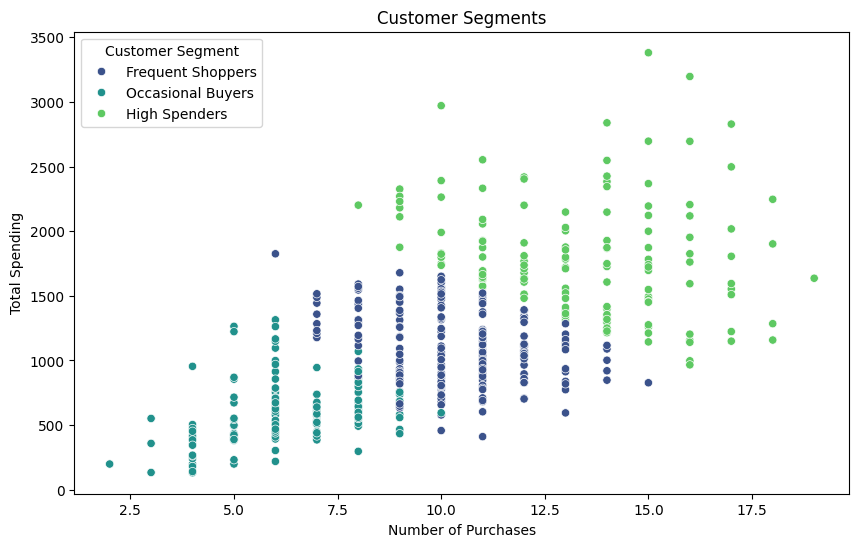

In [9]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=customer_spending, x='Purchase_Count', y='Total_Spent', hue='Segment', palette='viridis')
plt.xlabel('Number of Purchases')
plt.ylabel('Total Spending')
plt.title('Customer Segments')
plt.legend(title='Customer Segment')
plt.show()

In [11]:
high_spenders = customer_spending[customer_spending['Segment'] == 'High Spenders']
high_spenders_data = purchase_data[purchase_data['Customer ID'].isin(high_spenders['Customer ID'])]
category_spending = high_spenders_data.groupby('Product Category')['Purchase Amount'].sum().reset_index()
print(category_spending)

  Product Category  Purchase Amount
0            Books          7681.59
1         Clothing         34736.02
2      Electronics        116428.20
3          Grocery         12176.88
4  Health & Beauty         45068.25
5   Home & Kitchen         26399.40
